In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from math import sqrt
from pandas.tseries.offsets import DateOffset
import plotly.graph_objects as go

In [3]:
sales_train_validation = pd.read_csv('./Walmart Data/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('./Walmart Data/sales_train_evaluation.csv')
sell_prices = pd.read_csv('./Walmart Data/sell_prices.csv')
calendar = pd.read_csv('./Walmart Data/calendar.csv')
sample_submission = pd.read_csv('./Walmart Data/sample_submission.csv')

In [4]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [5]:
calendar['combined_event_type'] = calendar.apply(
    lambda row: row['event_type_1'] if pd.isnull(row['event_type_2'])
    else row['event_type_1'] + ' & ' + row['event_type_2'],
    axis=1
)

In [278]:
'''Data pre-processing'''

'Data pre-processing'

In [6]:
item_category_sales = sales_train_validation.groupby(['item_id', 'cat_id']).sum().iloc[:, -1913:].sum(axis=1).reset_index()

item_category_sales.columns = ['item_id', 'cat_id', 'total_sales']

top_10_per_category = item_category_sales.sort_values(['cat_id', 'total_sales'], ascending=[True, False]).groupby('cat_id').head(10)

sales_train_validation = sales_train_validation.loc[sales_train_validation['item_id'].isin(top_10_per_category['item_id'])]
sales_train_evaluation = sales_train_evaluation.loc[sales_train_evaluation['item_id'].isin(top_10_per_category['item_id'])]

In [7]:
# Melt sales data to long format
sales_train_validation = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')

sales_train_validation['day'] = sales_train_validation['day'].apply(lambda x: x[2:]).astype(int)
data = pd.merge(sales_train_validation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
data['date'] = pd.to_datetime(data['date'])
data = pd.merge(data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [8]:
#Same for Evaluation Dataset
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_evaluation['day'] = sales_train_evaluation['day'].apply(lambda x: x[2:]).astype(int)
eval_data = pd.merge(sales_train_evaluation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
eval_data['date'] = pd.to_datetime(eval_data['date'])
eval_data = pd.merge(eval_data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [9]:
# Create a list of all the event/holiday columns
event_columns = [col for col in data.columns if 'event' in col]

# Create a new column 'is_event_or_holiday' that is True if any event/holiday is True, False otherwise
data['is_event_or_holiday'] = data[event_columns].any(axis=1)
eval_data['is_event_or_holiday'] = eval_data[event_columns].any(axis=1)

In [10]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data['weekday'] = pd.Categorical(data['weekday'], categories=days_order, ordered=True)
eval_data['weekday'] = pd.Categorical(eval_data['weekday'], categories=days_order, ordered=True)

In [11]:
data.sort_values(by=['id', 'date'], inplace=True)
eval_data.sort_values(by=['id', 'date'], inplace=True)

In [ ]:
''' Group and Create Lagged Features
data['sales_lag_1'] = data.groupby(['id'])['sales'].shift(1)
data['sales_lag_7'] = data.groupby(['id'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['id'])['sales'].shift(30)

eval_data['sales_lag_1'] = eval_data.groupby(['id'])['sales'].shift(1)
eval_data['sales_lag_7'] = eval_data.groupby(['id'])['sales'].shift(7)
eval_data['sales_lag_30'] = eval_data.groupby(['id'])['sales'].shift(30)

data['sales_rolling_mean_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
data['sales_rolling_mean_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
data['sales_rolling_std_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
data['sales_rolling_std_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

eval_data['sales_rolling_mean_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
eval_data['sales_rolling_mean_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
eval_data['sales_rolling_std_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
eval_data['sales_rolling_std_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

chunk_size = 100000
num_chunks = len(data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

data = pd.concat(processed_data, ignore_index=True)

chunk_size = 100000
num_chunks = len(eval_data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = eval_data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

eval_data = pd.concat(processed_data, ignore_index=True)

'''

In [12]:
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week.astype(int)
data['start_of_month'] = (data['date'].dt.day == 1).astype(int)
data['is_august'] = (data['month'] == 8).astype(int)
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

In [13]:
eval_data['day_of_week'] = eval_data['date'].dt.dayofweek
eval_data['week_of_year'] = eval_data['date'].dt.isocalendar().week.astype(int)
eval_data['start_of_month'] = (eval_data['date'].dt.day == 1).astype(int)
eval_data['is_august'] = (eval_data['month'] == 8).astype(int)
eval_data['is_weekend'] = (eval_data['day_of_week'] >= 5).astype(int)

In [14]:
data['snap_CA_sales'] = np.where(data['state_id'] == 'CA', data['snap_CA'] * data['sales'], 0)
data['snap_TX_sales'] = np.where(data['state_id'] == 'TX', data['snap_TX'] * data['sales'], 0)
data['snap_WI_sales'] = np.where(data['state_id'] == 'WI', data['snap_WI'] * data['sales'], 0)

In [15]:
eval_data['snap_CA_sales'] = np.where(eval_data['state_id'] == 'CA', eval_data['snap_CA'] * eval_data['sales'], 0)
eval_data['snap_TX_sales'] = np.where(eval_data['state_id'] == 'TX', eval_data['snap_TX'] * eval_data['sales'], 0)
eval_data['snap_WI_sales'] = np.where(eval_data['state_id'] == 'WI', eval_data['snap_WI'] * eval_data['sales'], 0)

In [16]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type', 'weekday']
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

In [17]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type', 'weekday']
for col in categorical_columns:
    eval_data[col] = eval_data[col].astype('category').cat.codes

In [26]:
'''XGBosst Model'''

'XGBosst Model'

In [18]:
data['day_of_month'] = data['date'].dt.day
eval_data['day_of_month'] = eval_data['date'].dt.day

In [28]:
data.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,wm_yr_wk,...,is_event_or_holiday,day_of_week,week_of_year,start_of_month,is_august,is_weekend,snap_CA_sales,snap_TX_sales,snap_WI_sales,day_of_month
572689,299,29,2,2,9,2,1909,2,2016-04-20,11612,...,False,2,16,0,0,0,0,0,0,20
572989,299,29,2,2,9,2,1910,2,2016-04-21,11612,...,False,3,16,0,0,0,0,0,0,21
573289,299,29,2,2,9,2,1911,1,2016-04-22,11612,...,False,4,16,0,0,0,0,0,0,22
573589,299,29,2,2,9,2,1912,7,2016-04-23,11613,...,False,5,16,0,0,1,0,0,0,23
573889,299,29,2,2,9,2,1913,5,2016-04-24,11613,...,False,6,16,0,0,1,0,0,0,24


In [19]:
max_date = data['date'].max()
cutoff_date = max_date - DateOffset(days=180)

X_train = data[data['date'] <= cutoff_date].drop(['sales'], axis=1)
y_train = data[data['date'] <= cutoff_date]['sales']

X_valid = data[data['date'] > cutoff_date].drop(['sales'], axis=1)
y_valid = data[data['date'] > cutoff_date]['sales']

In [20]:
X_train = X_train.drop(columns=['date'])
X_valid = X_valid.drop(columns=['date'])

In [21]:
eval_data = eval_data.groupby('id').apply(lambda x: x.tail(28))
eval_data.reset_index(drop=True, inplace=True)

In [22]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse', 
    'eta': 0.1, # learning rate
    'max_depth': 6,     
    'subsample': 0.7,   
    'colsample_bytree': 0.7,  
    'enable_categorical': True
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=50, evals=[(dvalid, 'eval')])

[15:59:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "enable_categorical" } are not used.

[0]	eval-rmse:18.98072
[1]	eval-rmse:17.72459
[2]	eval-rmse:16.57708
[3]	eval-rmse:15.67672
[4]	eval-rmse:14.84006
[5]	eval-rmse:14.08015
[6]	eval-rmse:13.42954
[7]	eval-rmse:12.80652
[8]	eval-rmse:12.35361
[9]	eval-rmse:11.87709
[10]	eval-rmse:11.49162
[11]	eval-rmse:11.18684
[12]	eval-rmse:10.89971
[13]	eval-rmse:10.68966
[14]	eval-rmse:10.48406
[15]	eval-rmse:10.23277
[16]	eval-rmse:10.05310
[17]	eval-rmse:9.91028
[18]	eval-rmse:9.70018
[19]	eval-rmse:9.57464
[20]	eval-rmse:9.49745
[21]	eval-rmse:9.43666
[22]	eval-rmse:9.30616
[23]	eval-rmse:9.25530
[24]	eval-rmse:9.24193
[25]	eval-rmse:9.20632
[26]	eval-rmse:9.14740
[27]	eval-rmse:9.10979
[28]	eval-rmse:9.04196
[29]	eval-rmse:8.99817
[30]	eval-rmse:8.96707
[31]	eval-rmse:8.90061
[32]	eval-rmse:8.86427
[33]	eval-rmse:8.83802
[34

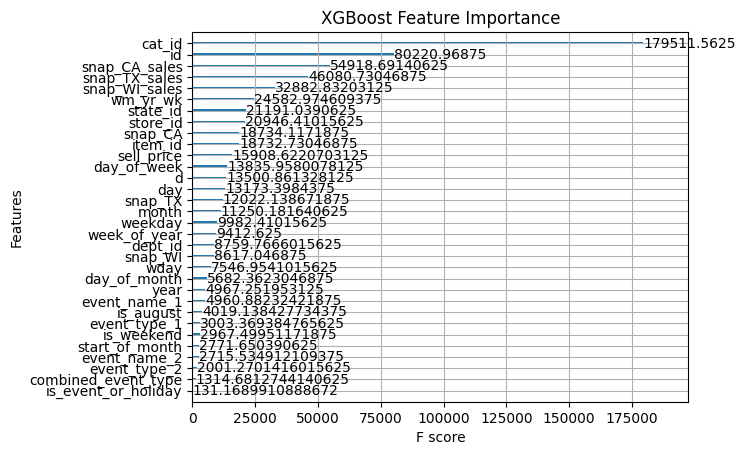

In [23]:
xgb.plot_importance(model, importance_type='gain')
plt.title('XGBoost Feature Importance')
plt.show()

In [24]:
y_pred_valid = model.predict(xgb.DMatrix(X_valid))

In [25]:
X_valid.rename(columns={'day': 'index_day'}, inplace=True)
X_valid.rename(columns={'day_of_month': 'day'}, inplace=True)
X_valid['date'] = pd.to_datetime(X_valid[['year', 'month', 'day']])

In [26]:
results_df = pd.DataFrame({
    'date': X_valid['date'],
    'item_id': X_valid['id'],
    'actual': y_valid.values,
    'predicted': y_pred_valid
})

In [27]:
rmse = np.sqrt(mean_squared_error(results_df['actual'], results_df['predicted']))
print('Overall RMSE:', rmse)
mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
print('Overall MAE:', mae)

Overall RMSE: 7.178058256577114
Overall MAE: 4.301020892602206


In [28]:
dtest = xgb.DMatrix(eval_data.drop(columns=['sales', 'date']))

y_pred_future = model.predict(dtest)

results_future_df = pd.DataFrame({
    'date': eval_data['date'],
    'item_id': eval_data['id'],
    'predicted': y_pred_future
})

In [29]:
results_future_df['actual'] = eval_data['sales']

In [31]:
results_future_df

,date,item_id,predicted,actual
0,2016-04-25,0,34.104744,48
1,2016-04-26,0,30.484797,35
2,2016-04-27,0,30.707727,34
3,2016-04-28,0,34.643425,67
4,2016-04-29,0,53.437386,63
...,...,...,...,...
8395,2016-05-18,299,12.436089,0
8396,2016-05-19,299,13.795193,5
8397,2016-05-20,299,15.543206,9
8398,2016-05-21,299,17.101051,5


In [30]:
rmse = np.sqrt(mean_squared_error(results_future_df['actual'], results_future_df['predicted']))
print('Overall RMSE:', rmse)

mae = mean_absolute_error(results_future_df['actual'], results_future_df['predicted'])
print('Overall MAE:', mae)

Overall RMSE: 6.458859001323713
Overall MAE: 4.211244902418195


In [45]:
grouped_eval_data = data.groupby('date')['sales'].sum().reset_index()
grouped_eval_data.columns = ['date', 'actual_sales']
grouped_predicted_data = results_df.groupby('date')['predicted'].sum().reset_index()

In [46]:
future_prediction = results_future_df.groupby('date')[['predicted','actual']].sum().reset_index()

In [47]:
merged_data = pd.merge(grouped_predicted_data, grouped_eval_data, on='date', how='left')

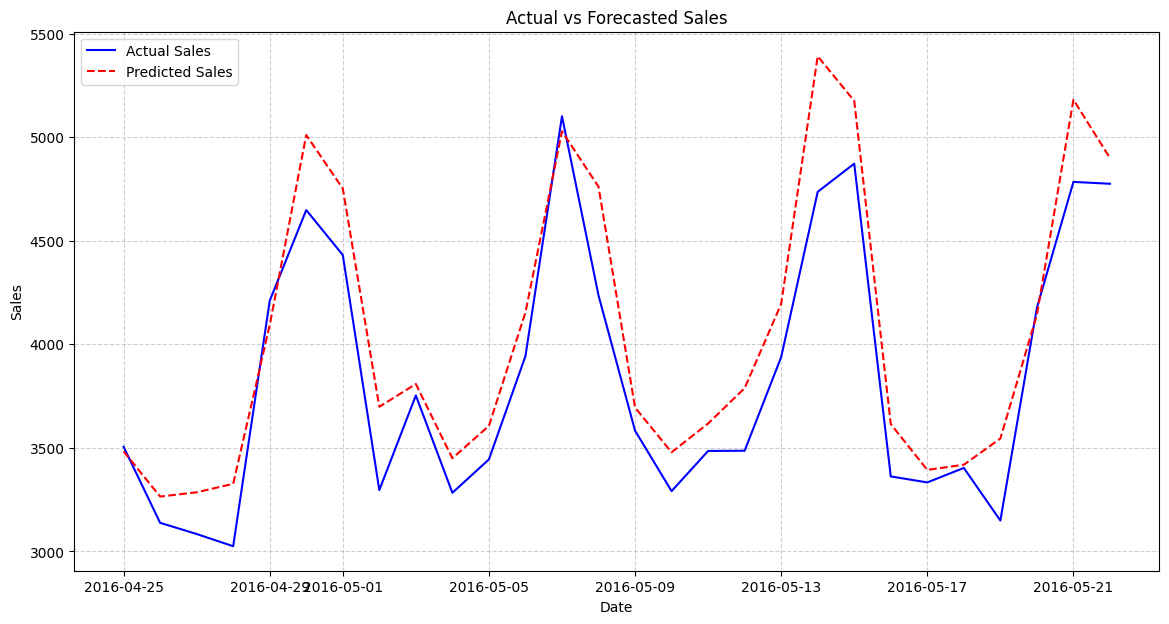

In [48]:
plt.figure(figsize=(14, 7))

plt.plot(future_prediction['date'], future_prediction['actual'], label='Actual Sales', color='blue')
plt.plot(future_prediction['date'], future_prediction['predicted'], label='Predicted Sales', color='red', linestyle='--')

plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [ ]:
unique_products = results_df['item_id'].unique()

for product_id in unique_products:
    
    product_data = results_df[results_df['item_id'] == product_id]
    
    plt.figure(figsize=(14, 7))
    plt.plot(product_data['date'], product_data['actual'], label='Actual')
    plt.plot(product_data['date'], product_data['predicted'], label='Predicted', linestyle='--')
    
    for date in product_data['date']:
        if date.day == 1:
            plt.axvline(x=date, color='red', linestyle='--', alpha=0.7)
    
    plt.title('Actual vs Predicted Sales for Product {}'.format(product_id))
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

In [49]:
results_df.to_excel('XGBoost_results.xlsx')
results_future_df.to_excel('XGBoost_results_28.xlsx')